In [1]:
import numpy as np
from calendar import isleap
import xarray as xr
import dask.array as da
import dask
import rioxarray as rio
# import pandas as pd
# import os
import matplotlib.pyplot as plt
# import warnings
import logging
logging.captureWarnings(True)

In [2]:
ny=1800
nx=4320
dtype_d=np.int16   # 2 byte integers for daily data
fillval_d=-9999   # daily
npts=2295358

# scale factors for putting the data in the pxv files into units in the table below
# in alphabetical order by variable name 
scale_factors=[0.0001,1000.,0.01,0.01,0.01,0.001]

# Variable	Monthly data	Daily deviations/distr.	Scale factor
# Precip	     mm/day	         %_of_month×100	       0.0001
# Srad	       J/m2/day	            kJ/m2/day	        1000.
# Tmax	         °C	                 °C×100	            0.01
# Tmin	         °C	                 °C×100	            0.01
# Vapr	         hPa	                Pa	            0.01
# Wind	        m/sec	              mm/sec	        0.001

In [3]:
# other constants 

# pxv things
pxv_basedir='/work/hpc/datasets/un_fao/gaez_v5/clim/AgERA5/Hist/'
dataset='AgERA5'
experiment='Hist'
pxvsuf='_5m.pxv'
connector='_'
dailytag='365'
sep='/'
pxvdirnames=['prec','srad','tmax','tmin','vapr','wind']
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m']

# raster things
maskfile='/work/hpc/datasets/un_fao/gaez_v5/land/ALOSmask5m_fill.rst'
ydimname='y'
xdimname='x'

yyyy=2020
doy_plot=275#15

# First, get the mask

In [4]:
### get the mask from the rst into an array of 2 dims (x,y)
### and check the mask has the same number of data grids as the pxv data

# open the maskfile but don't include antarctica so mask has shape (y:1800,x:4320)
ds=xr.open_dataset(maskfile,engine='rasterio').isel(y=slice(0,ny)).squeeze()
del ds.coords['band']

# clean up some metadata
ds[xdimname]=ds[xdimname].astype(np.float32)
ds[ydimname]=ds[ydimname].astype(np.float32)
mask2D=ds.band_data

# # convert to 0 & 1 mask
mask2D=xr.where(mask2D>0,1,0).astype('int8')

mask1D=mask2D.stack(space=[ydimname,xdimname]) # collapse mask to 1D: 1800*4320 = 7776000 points
inds_data=mask1D==1  # keep track of which points are not masked out

# plot data in monthly pxv files

min/max value of valid data pts before scaling: 0 10000
min/max value of valid data pts after scaling: 0.0 1.0


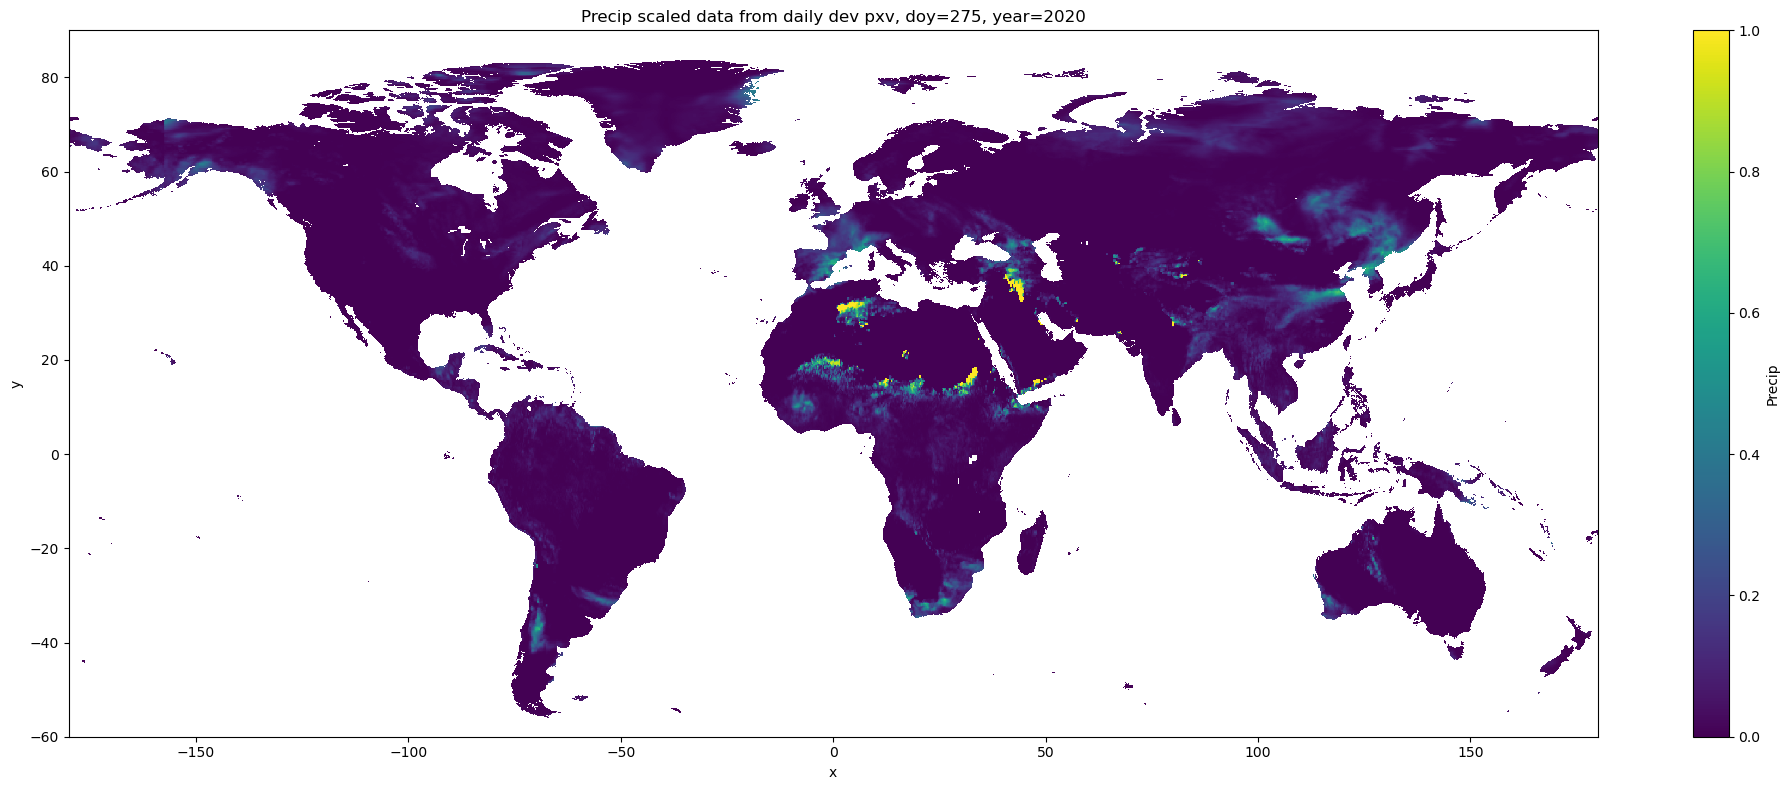

min/max value of valid data pts before scaling: -27299 21907
min/max value of valid data pts after scaling: -27299000.0 21907000.0


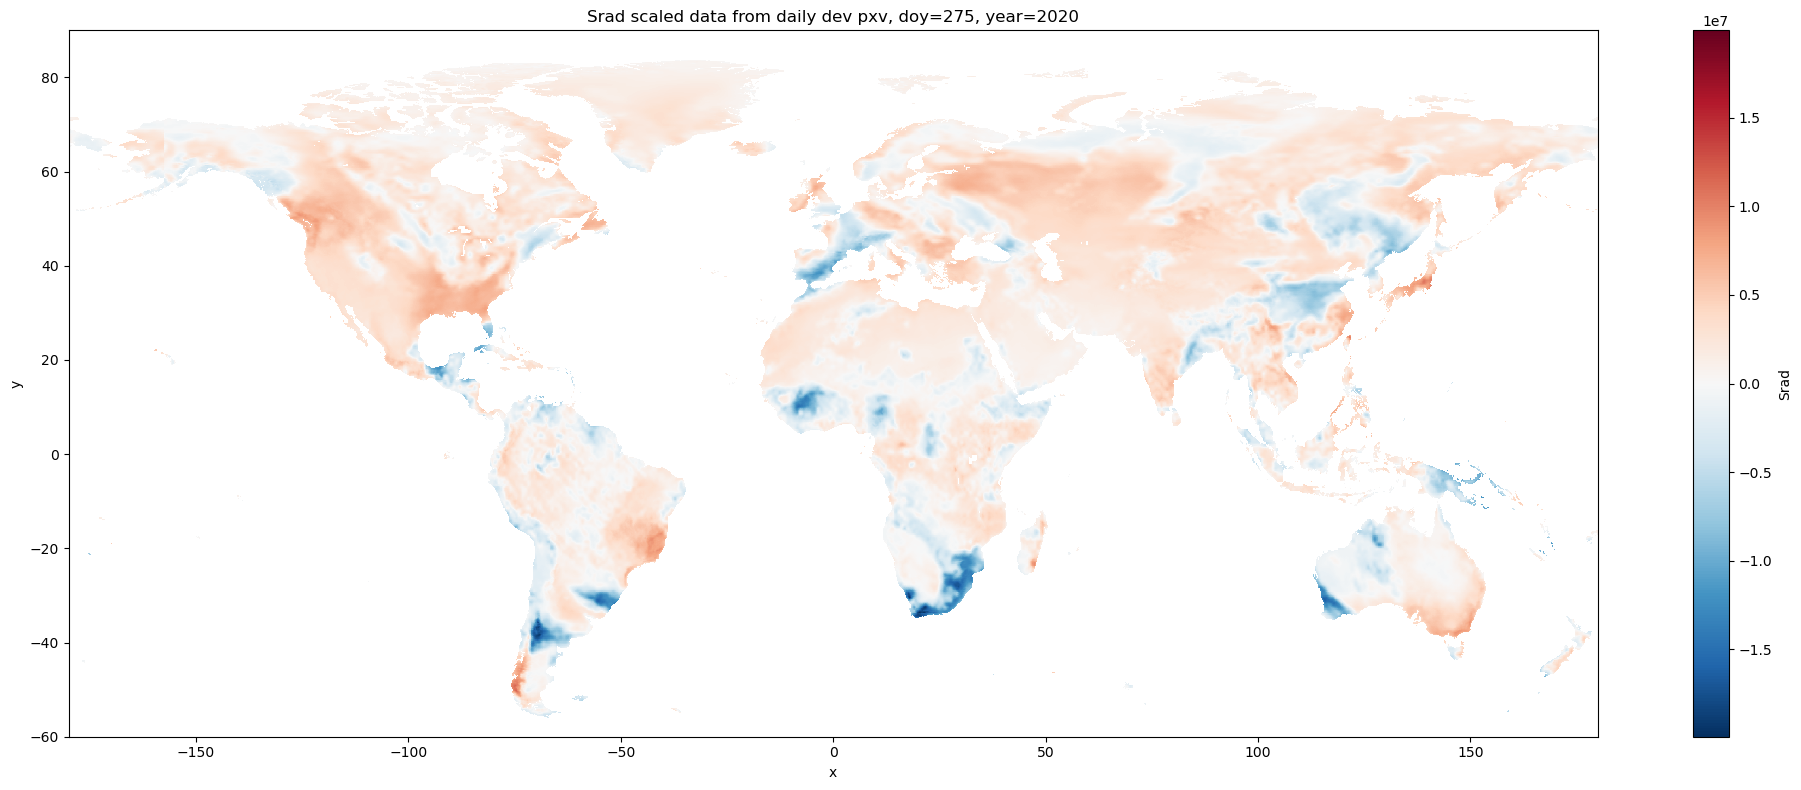

min/max value of valid data pts before scaling: -3175 8340
min/max value of valid data pts after scaling: -31.75 83.4


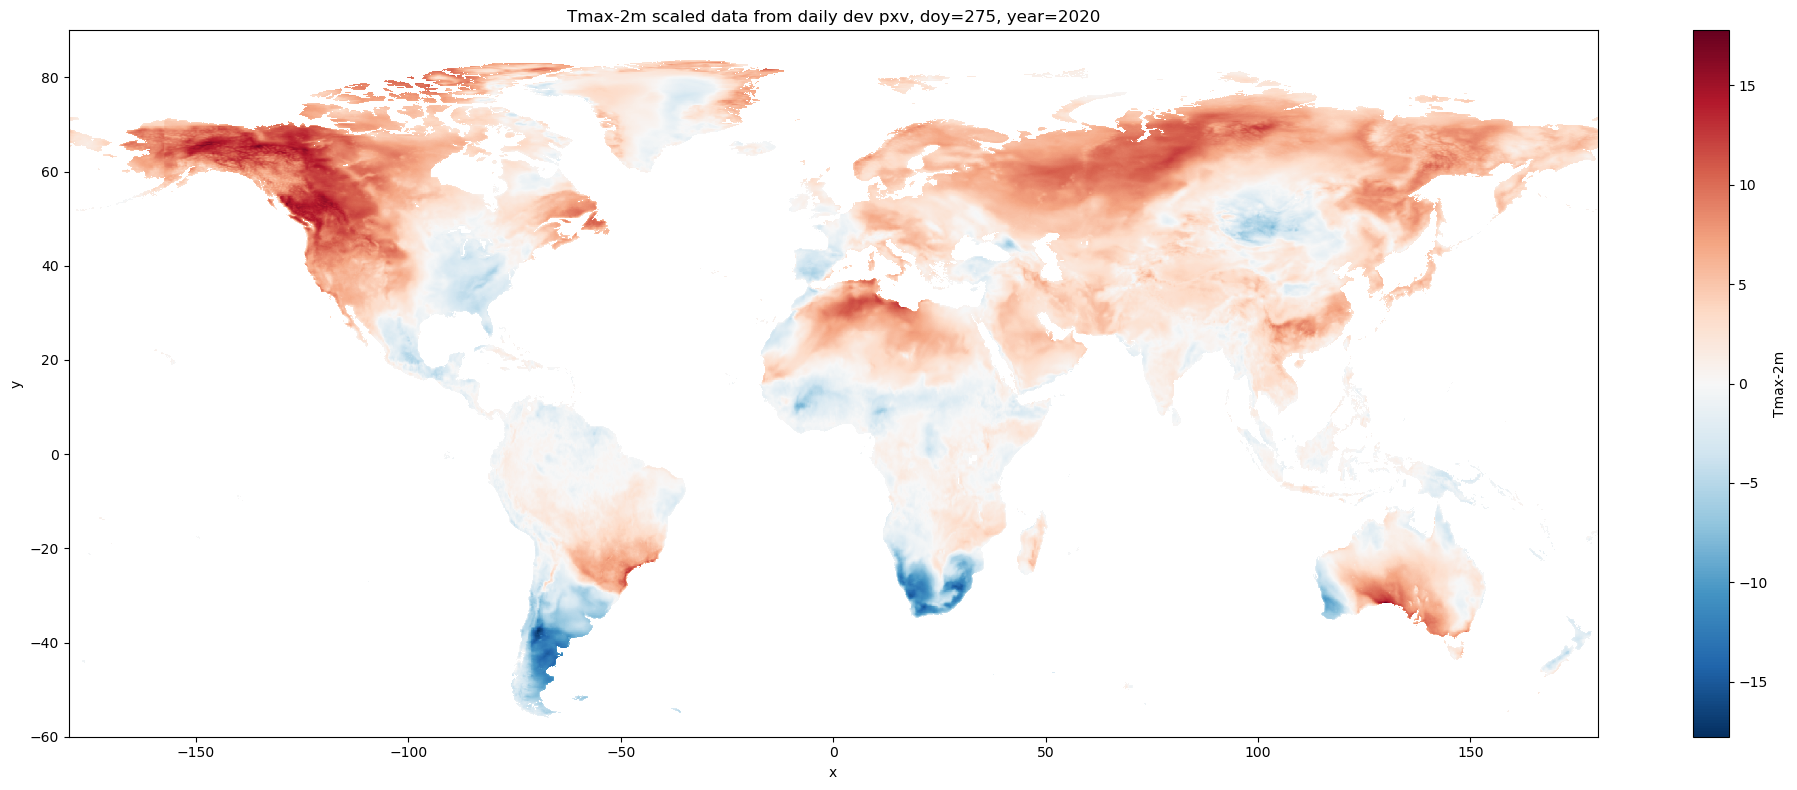

min/max value of valid data pts before scaling: -2955 8340
min/max value of valid data pts after scaling: -29.55 83.4


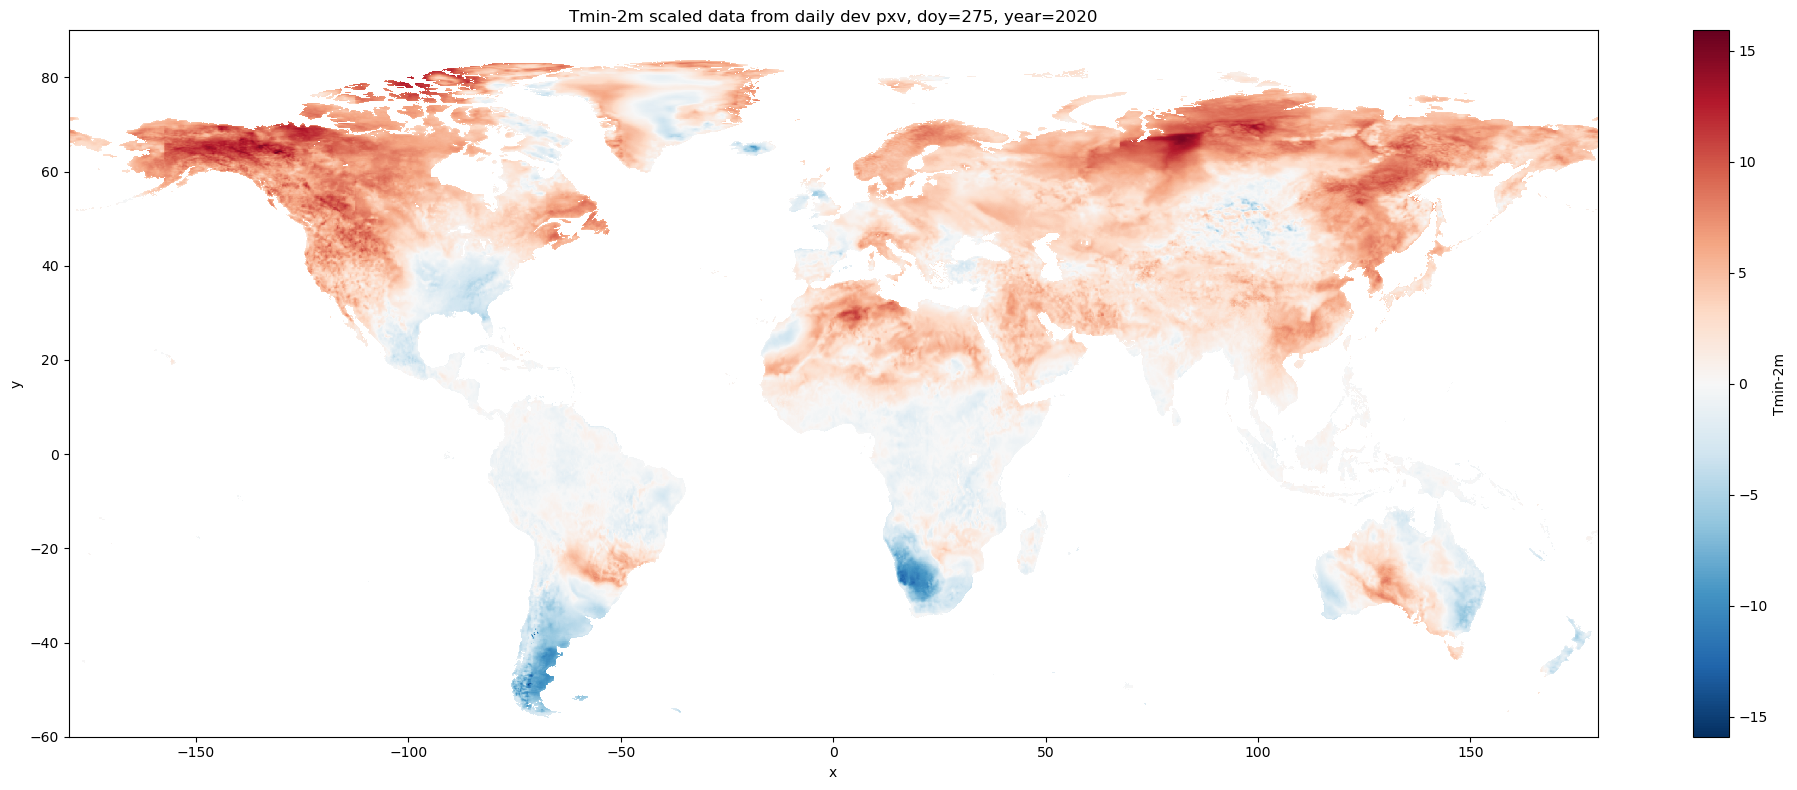

min/max value of valid data pts before scaling: -2363 2273
min/max value of valid data pts after scaling: -23.63 22.73


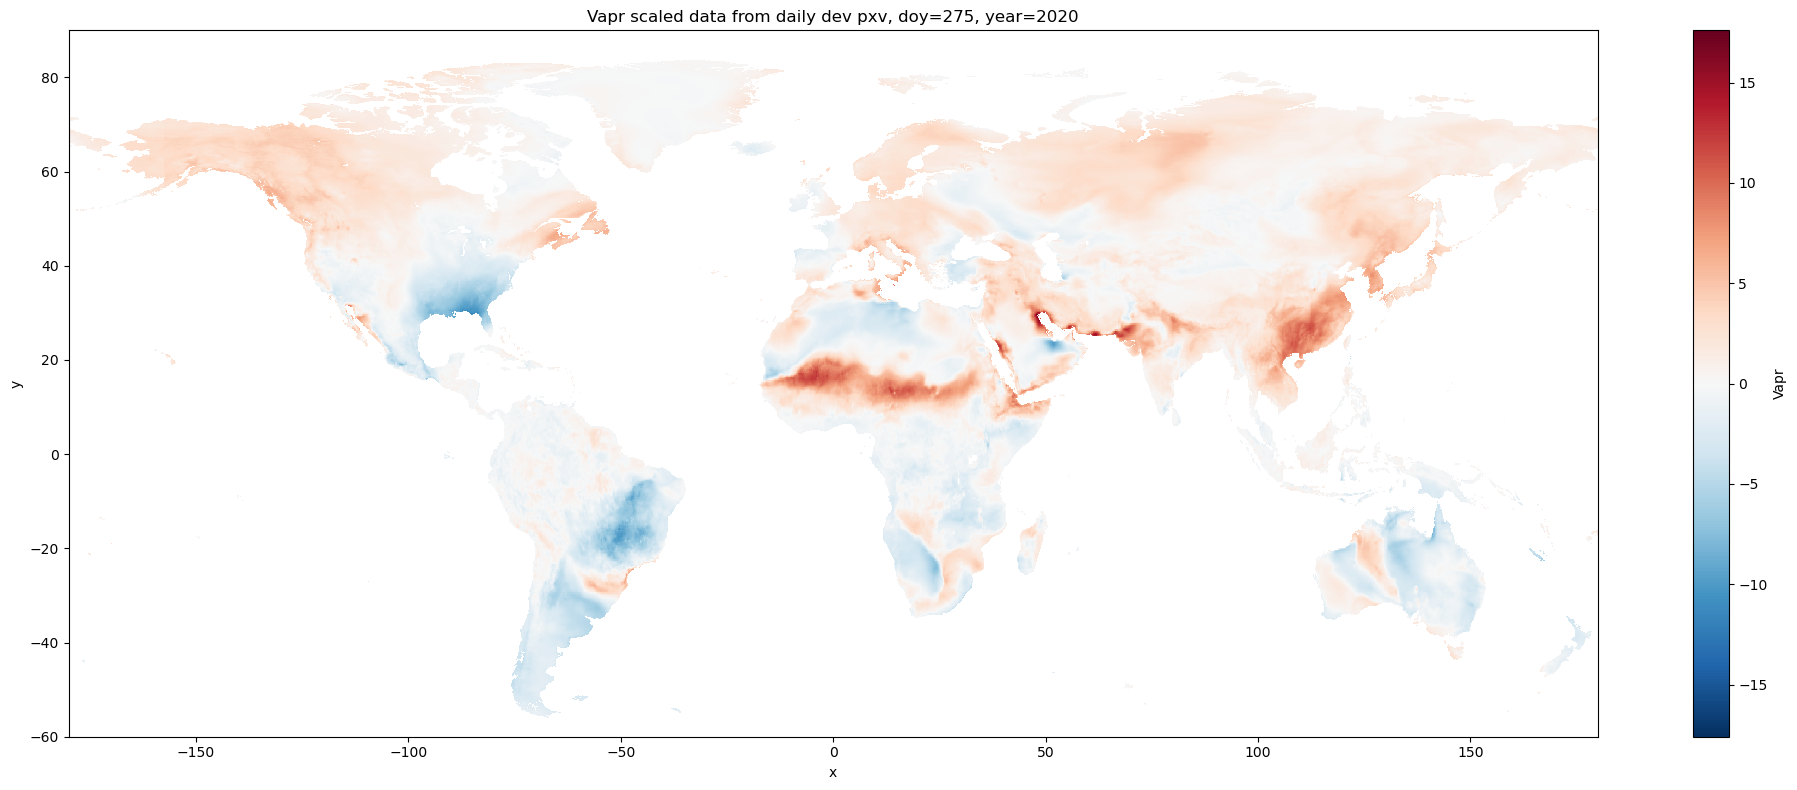

min/max value of valid data pts before scaling: -10241 23961
min/max value of valid data pts after scaling: -10.241 23.961


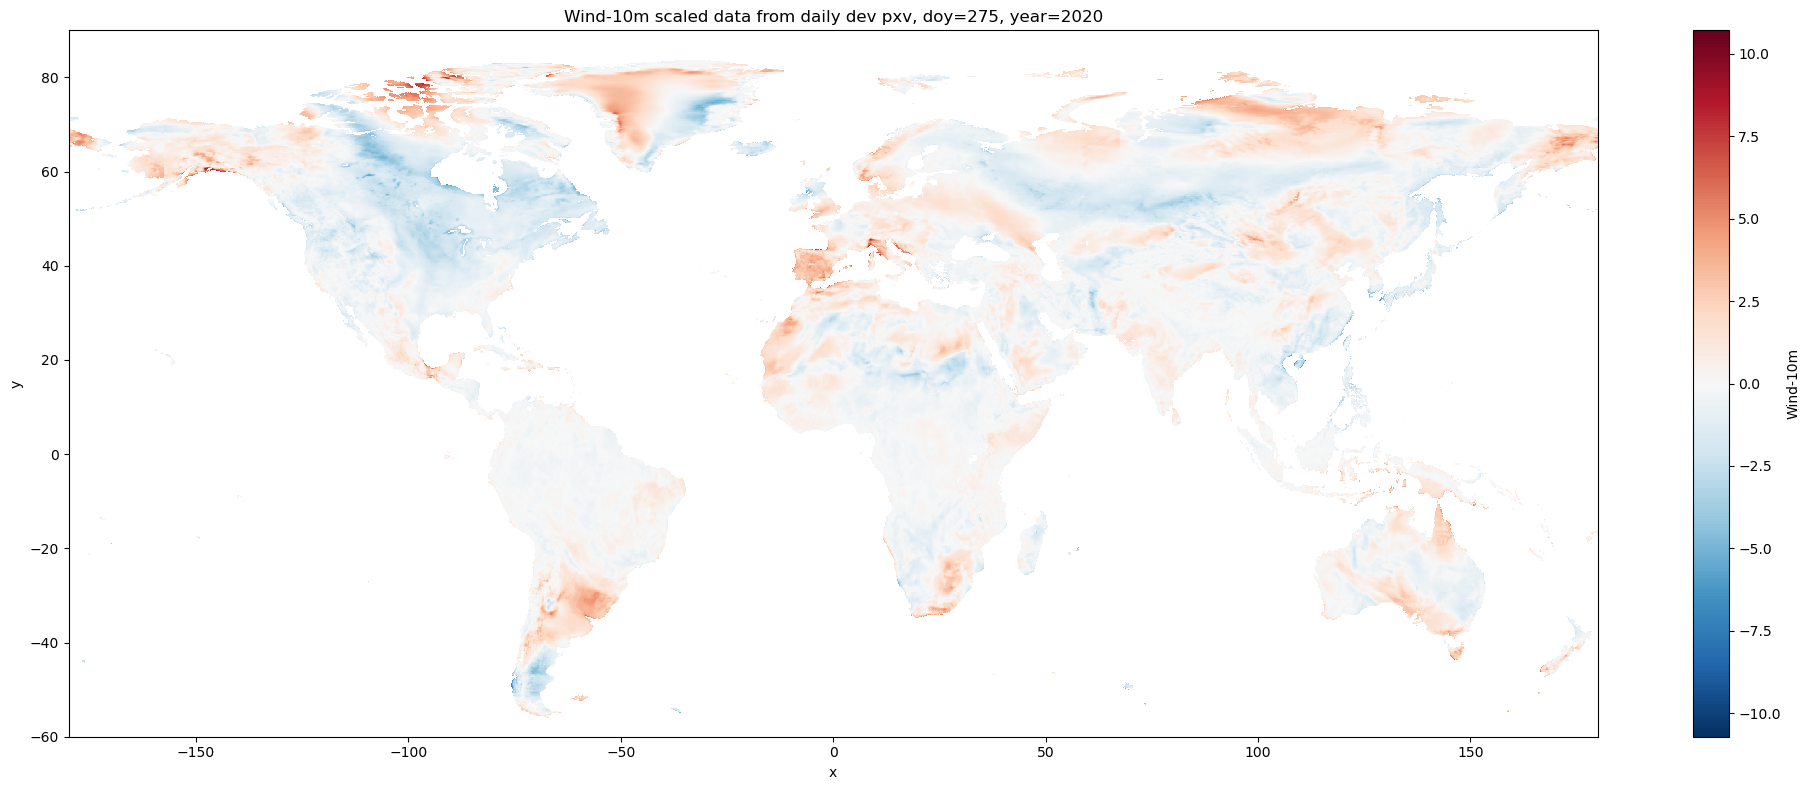

In [5]:
# function to call with dask delayed
def data_to_nd_array(i,inds,arr1D,pxv,arr2D):
    arr1D[inds]=pxv.squeeze()  # remove singleton dim (day)
    arr2D[:,:]=arr1D.unstack() # put 1D data onto the 2D grid
    return arr2D.copy()


for varind,(var,pdir) in enumerate(zip(varnames,pxvdirnames)):
    pxvfile=pxv_basedir+pdir+sep+var+dailytag+connector+dataset+connector+experiment+connector+str(yyyy)+pxvsuf
    filename=pxvfile.split(sep)[-1]

    # read entire file into 1D array
    with open(pxvfile,'rb') as f:
        array1D_d=np.fromfile(f,dtype=dtype_d)

    ndays=366 if isleap(yyyy) else 365 # number of days of data at each grid point

    array2D_d=array1D_d.reshape(npts,ndays) # reshape

    # print min/max info
    minval=array2D_d.min()
    maxval=array2D_d.max()
    if minval==fillval_d:
        temporary=array2D_d.copy()
        temporary=xr.where(temporary==fillval_d,maxval,temporary)
        minval=temporary.min()
        del temporary
    print('min/max value of valid data pts before scaling:',minval,maxval)

    # find out if data value range spans across the fillvalue
    # if it does, we'll need to apply an extra mask later
    flag_d=True if array2D_d.min() < fillval_d else False    

    
    # put data on full global grid

    # set up 
    empty1D_d=mask1D.copy().astype(dtype_d)  # placeholder array for 1D space 
    empty1D_d.rio.write_nodata(fillval_d,inplace=True)
    empty1D_d[:]=fillval_d

    empty2D_d=mask2D.copy().astype(dtype_d)  # placeholder array for 2D grid 
    empty2D_d.rio.write_nodata(fillval_d,inplace=True)
    empty2D_d[:,:]=fillval_d

    # using dask parallel computing
    # with warnings.catch_warnings():    
    pxv_delay=da.from_array(array2D_d,chunks=(-1,1)).to_delayed().ravel() # create data futures    
    task_list=[dask.delayed(data_to_nd_array)(iday,inds_data,empty1D_d.copy(),pxvdata,empty2D_d.copy()) for iday,pxvdata in enumerate(pxv_delay)]# lazy tasks
    assert len(task_list)==ndays, f'{len(task_list)} tasks in list, should be {ndays}' # double check we've got 1 task per day of data
    result_chunks_d=dask.compute(*task_list) # execute all computations
    data3D_d=xr.concat(result_chunks_d,dim='time') # concatenate the resulting monthly chunks along a new time dimension

    # scale and mask if necessary
    data3D_d=data3D_d.astype(np.float32)
    # if valid data range includes fillval, scale then additional masking
    if flag_d:
    # if var!='Precip':
        data3D_d=data3D_d*scale_factors[varind]    
        data3D_d=xr.where(data_mask_d,data3D_d,np.nan)
    # if valid data range doesn't include fillval, convert fillval to nan then scale
    else:
        data3D_d=xr.where(data3D_d==fillval_d,np.nan,data3D_d)
        data3D_d=data3D_d*scale_factors[varind]
        if var =='Precip':
            data_mask_d=xr.where(np.isnan(data3D_d.data),0,1)  

    print('min/max value of valid data pts after scaling:',data3D_d.min().data,data3D_d.max().data)
            
    # visual check January
    data3D_d=data3D_d.rename(var)
    figure=plt.figure(figsize=(20,8))
    data3D_d.isel(time=doy_plot).plot()
    plt.title(var+' scaled data from daily dev pxv, doy='+str(doy_plot)+', year='+str(yyyy))
    plt.tight_layout()
    plt.show()    
    
    # del array1D_d,pxvfile,filename,minval,maxval,array2D_d,flag_d,empty1D_d,empty2D_d,pxv_delay,task_list,result_chunks_d,data3D_d,figure           